참고 링크  : https://wikidocs.net/233131

---

# 시계열 분석을 해보자!

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.spatial import cKDTree
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
school = pd.read_csv('../data/schoolinfo.csv')
subway = pd.read_csv('../data/subwayInfo.csv')
park = pd.read_csv('../data/parkInfo.csv')
interest = pd.read_csv('../data/interestRate.csv')

In [3]:
greater_Seoul_school = school[
    (school['latitude'] >= 36.76950200) & (school['longitude'] <= 127.72379200)
]

greater_Seoul_park = park[
    (park['latitude'] >= 36.76950200) & (park['longitude'] <= 127.72379200)
]

In [4]:
train['type'] = 'train' 
test['type'] = 'test'    

df = pd.concat([train, test], axis=0)


In [5]:
df['contract_date'] = pd.to_datetime(df['contract_year_month'], format='%Y%m')

# 연도와 월 변수 생성
df['contract_year'] = df['contract_date'].dt.year
df['contract_month'] = df['contract_date'].dt.month


In [6]:
df['deposit_by_area'] = df['deposit'] / df['area_m2']
df


,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit,type,contract_date,contract_year,contract_month,deposit_by_area
0,0,84.9981,201906,25,2,9,2019,37.054314,127.045216,0,17000.0,train,2019-06-01,2019,6,200.004471
1,1,84.9981,202003,26,2,20,2019,37.054314,127.045216,1,23000.0,train,2020-03-01,2020,3,270.594284
2,2,84.9981,202003,28,2,8,2019,37.054314,127.045216,1,23000.0,train,2020-03-01,2020,3,270.594284
3,3,59.3400,201907,15,2,1,1986,36.964647,127.055847,33,5000.0,train,2019-07-01,2019,7,84.260195
4,4,59.8100,201904,12,2,6,1995,36.972390,127.084514,24,1800.0,train,2019-04-01,2019,4,30.095302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150167,150167,115.5101,202402,27,0,17,2010,37.528394,126.659398,14,NaN,test,2024-02-01,2024,2,NaN
150168,150168,142.8738,202403,2,0,4,2010,37.528394,126.659398,14,NaN,test,2024-03-01,2024,3,NaN
150169,150169,142.8738,202403,16,1,13,2010,37.528394,126.659398,14,NaN,test,2024-03-01,2024,3,NaN
150170,150170,114.9285,202403,22,1,2,2010,37.528394,126.659398,14,NaN,test,2024-03-01,2024,3,NaN


## 1. 시계열 시각화

### 추세
- 계절성 패턴은 반복 길이가 고정적
- 주기성 패턴은 반복 길이가 고정되지 않으며, 일정하지 않은 주기를 가지고 나타남

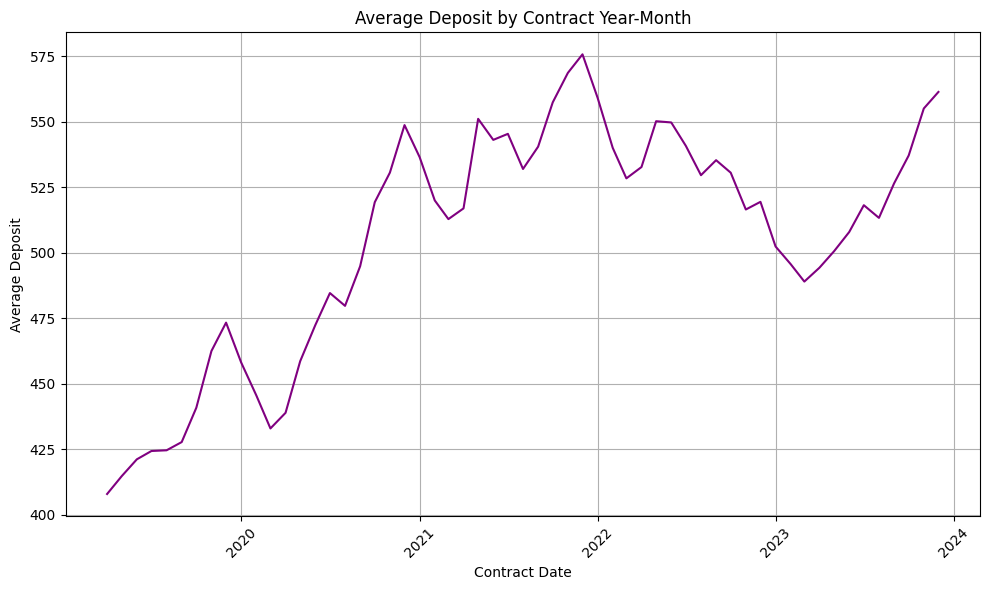

In [7]:
# deposit_by_area 추세
avg_area_deposit_by_month = df.groupby('contract_date')['deposit_by_area'].mean()

plt.figure(figsize=(10, 6))
plt.plot(avg_area_deposit_by_month.index, avg_area_deposit_by_month.values, linestyle='-', color='purple')
plt.xticks(rotation=45)  
plt.title('Average Deposit by Contract Year-Month')
plt.xlabel('Contract Date')
plt.ylabel('Average Deposit')
plt.grid(True)
plt.tight_layout()
plt.show()

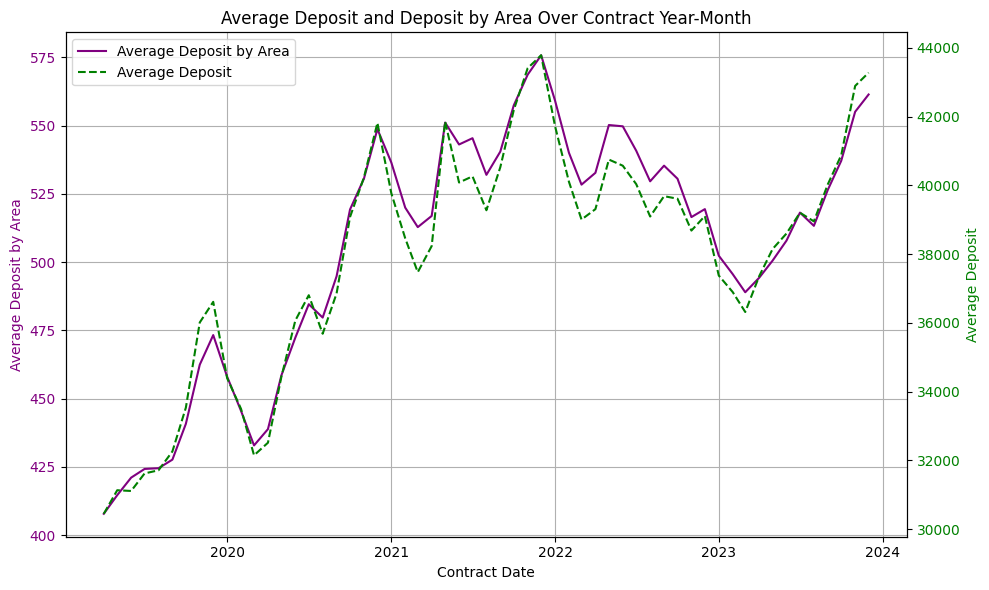

In [8]:
avg_area_deposit_by_month = df.groupby('contract_date')['deposit_by_area'].mean()
avg_deposit_by_month = df.groupby('contract_date')['deposit'].mean()

fig, ax1 = plt.subplots(figsize=(10, 6))

line1, = ax1.plot(avg_area_deposit_by_month.index, avg_area_deposit_by_month.values, linestyle='-', color='purple', label='Average Deposit by Area')
ax1.set_xlabel('Contract Date')
ax1.set_ylabel('Average Deposit by Area', color='purple')
ax1.tick_params(axis='y', labelcolor='purple')
ax1.grid(True)

ax2 = ax1.twinx()
line2, = ax2.plot(avg_deposit_by_month.index, avg_deposit_by_month.values, linestyle='--', color='green', label='Average Deposit')
ax2.set_ylabel('Average Deposit', color='green')
ax2.tick_params(axis='y', labelcolor='green')

lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')

plt.title('Average Deposit and Deposit by Area Over Contract Year-Month')
fig.tight_layout()

plt.show()


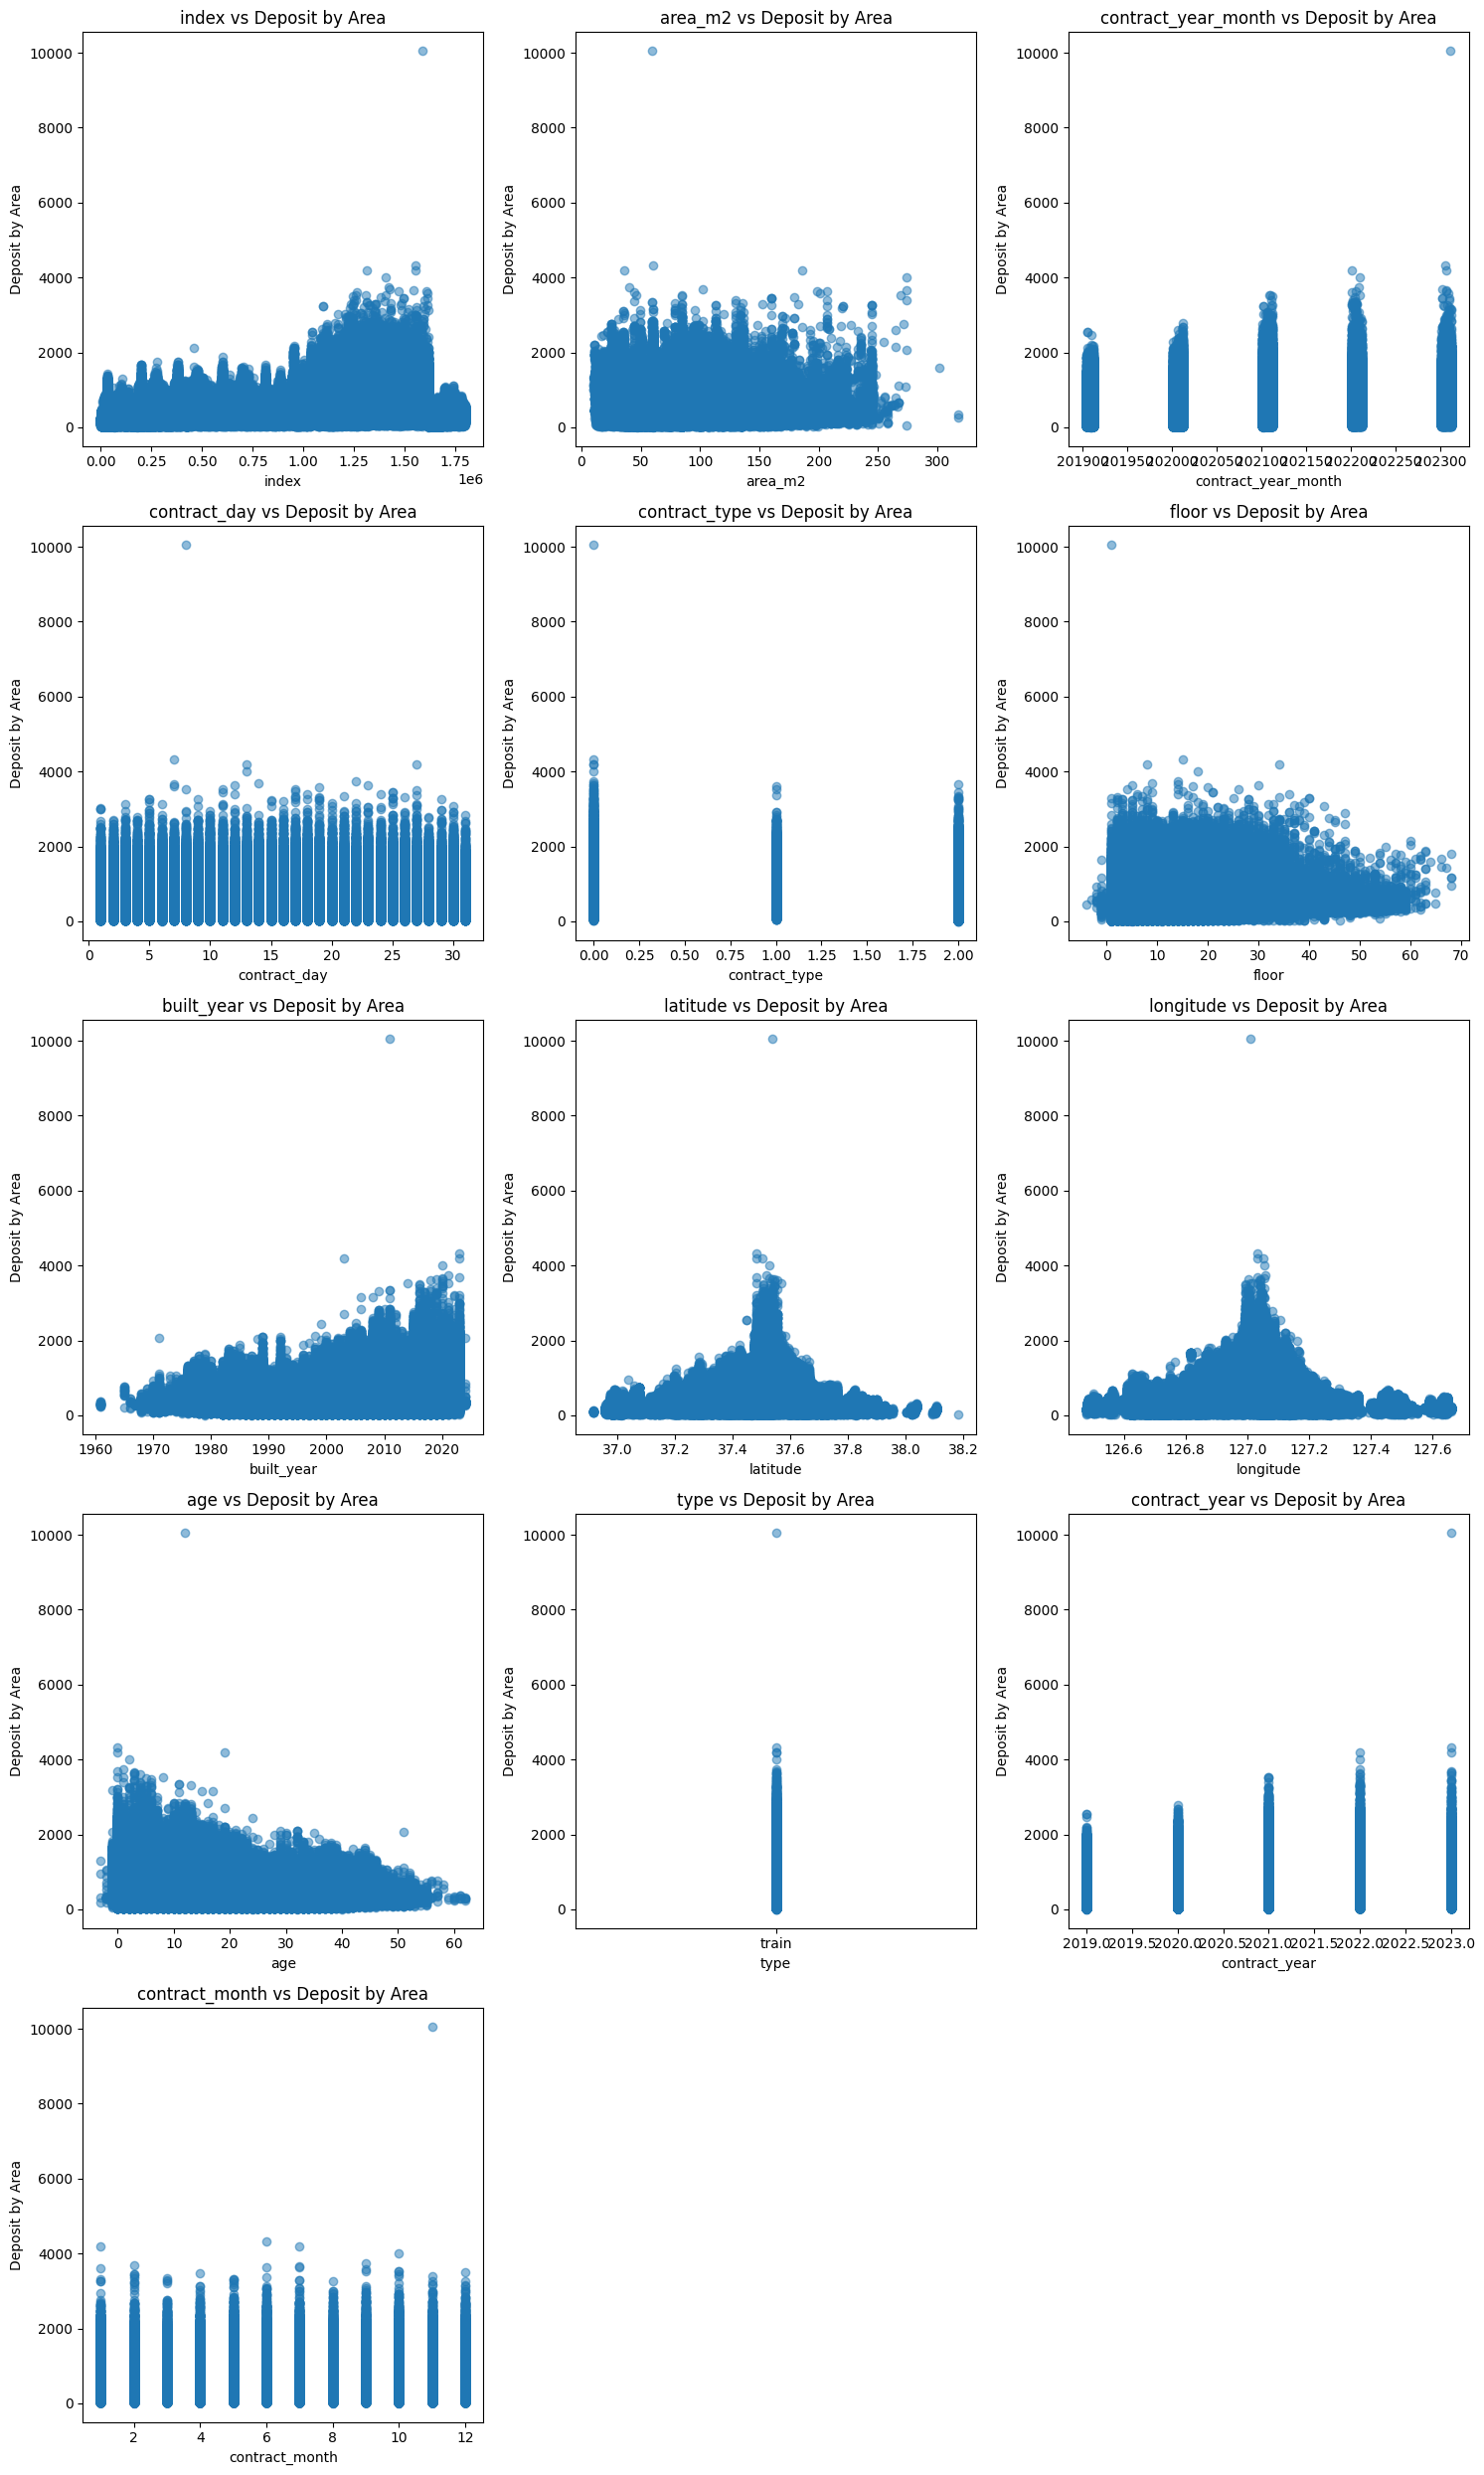

In [9]:
x_columns = df.columns.drop(['deposit_by_area', 'deposit', 'contract_date'])

n_cols = 3
n_rows = (len(x_columns) + n_cols - 1) // n_cols  

plt.figure(figsize=(15, 5 * n_rows))  
for i, col in enumerate(x_columns, 1):
    plt.subplot(n_rows, n_cols, i)
    plt.scatter(df[col], df['deposit_by_area'], alpha=0.5)
    plt.title(f'{col} vs Deposit by Area')
    plt.xlabel(col)
    plt.ylabel('Deposit by Area')

plt.tight_layout()  
plt.show()


In [13]:
# 한남더힐
df[df['deposit_by_area'] == max(df['deposit_by_area'])]

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit,type,contract_date,contract_year,contract_month,deposit_by_area
1588478,1588478,59.7,202311,8,0,1,2011,37.537547,127.010049,12,600000.0,train,2023-11-01,2023,11,10050.251256


In [15]:
df[(df['latitude']==37.537547) & (df['longitude']==127.010049) & (df['area_m2']==59.7) ]

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit,type,contract_date,contract_year,contract_month,deposit_by_area
948832,948832,59.7,201904,12,2,3,2011,37.537547,127.010049,8,115000.0,train,2019-04-01,2019,4,1926.298157
948916,948916,59.7,201909,2,2,2,2011,37.537547,127.010049,8,110000.0,train,2019-09-01,2019,9,1842.546064
948956,948956,59.7,201911,3,2,2,2011,37.537547,127.010049,8,105000.0,train,2019-11-01,2019,11,1758.793970
1166885,1166885,59.7,202009,14,2,6,2011,37.537547,127.010049,9,110000.0,train,2020-09-01,2020,9,1842.546064
1171518,1171518,59.7,202101,16,2,2,2011,37.537547,127.010049,10,140000.0,train,2021-01-01,2021,1,2345.058626
1314696,1314696,59.7,202202,23,1,3,2011,37.537547,127.010049,11,152140.0,train,2022-02-01,2022,2,2548.408710
1582499,1582499,59.7,202307,7,0,3,2011,37.537547,127.010049,12,145000.0,train,2023-07-01,2023,7,2428.810720
1588478,1588478,59.7,202311,8,0,1,2011,37.537547,127.010049,12,600000.0,train,2023-11-01,2023,11,10050.251256


In [17]:
df[(df['latitude']==37.537547) & (df['longitude']==127.010049) & (df['floor']==1) ]

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit,type,contract_date,contract_year,contract_month,deposit_by_area
948845,948845,177.764,201905,2,2,1,2011,37.537547,127.010049,8,270000.0,train,2019-05-01,2019,5,1518.867712
948866,948866,59.686,201906,8,2,1,2011,37.537547,127.010049,8,110000.0,train,2019-06-01,2019,6,1842.978253
948918,948918,243.642,201909,4,2,1,2011,37.537547,127.010049,8,490000.0,train,2019-09-01,2019,9,2011.147503
948931,948931,59.686,201909,28,2,1,2011,37.537547,127.010049,8,115000.0,train,2019-09-01,2019,9,1926.749992
948961,948961,208.478,201911,12,2,1,2011,37.537547,127.010049,8,290000.0,train,2019-11-01,2019,11,1391.034066
1164042,1164042,59.686,202007,18,2,1,2011,37.537547,127.010049,9,125000.0,train,2020-07-01,2020,7,2094.293469
1302315,1302315,177.764,202105,28,2,1,2011,37.537547,127.010049,10,375000.0,train,2021-05-01,2021,5,2109.538489
1309428,1309428,243.642,202111,3,2,1,2011,37.537547,127.010049,10,505000.0,train,2021-11-01,2021,11,2072.713243
1309430,1309430,243.642,202111,3,1,1,2011,37.537547,127.010049,10,505000.0,train,2021-11-01,2021,11,2072.713243
1456793,1456793,59.686,202210,12,1,1,2011,37.537547,127.010049,11,131250.0,train,2022-10-01,2022,10,2199.008143


In [22]:
sorted(df['deposit_by_area'],reverse=True)[:10]

[10050.251256281406,
 4319.5463642428285,
 4194.675988168863,
 4190.412336573919,
 4015.184698496131,
 3743.448964312453,
 3676.831061868811,
 3650.1679077237554,
 3632.346041499554,
 3625.021931382685]

- 이상치 아닐까.....?

### 지연 그래프
- 지연 그래프(Lag Plot)는 시계열 데이터에서 시간에 따른 자기상관성을 파악하는 데 사용 
- 자기상관성(Autocorrelation)은 시계열 데이터에서 현재 시점의 데이터와 과거 시점의 데이터 사이에 존재하는 상관관계를 의미
-  시점 간의 관계를 분석 가능
- 지연(Lag)은 현재 시점의 값과 일정 시간 이전의 값 사이의 차이를 의미

-> 계절성, 주기성을 시각적으로 파악할 수 있다.

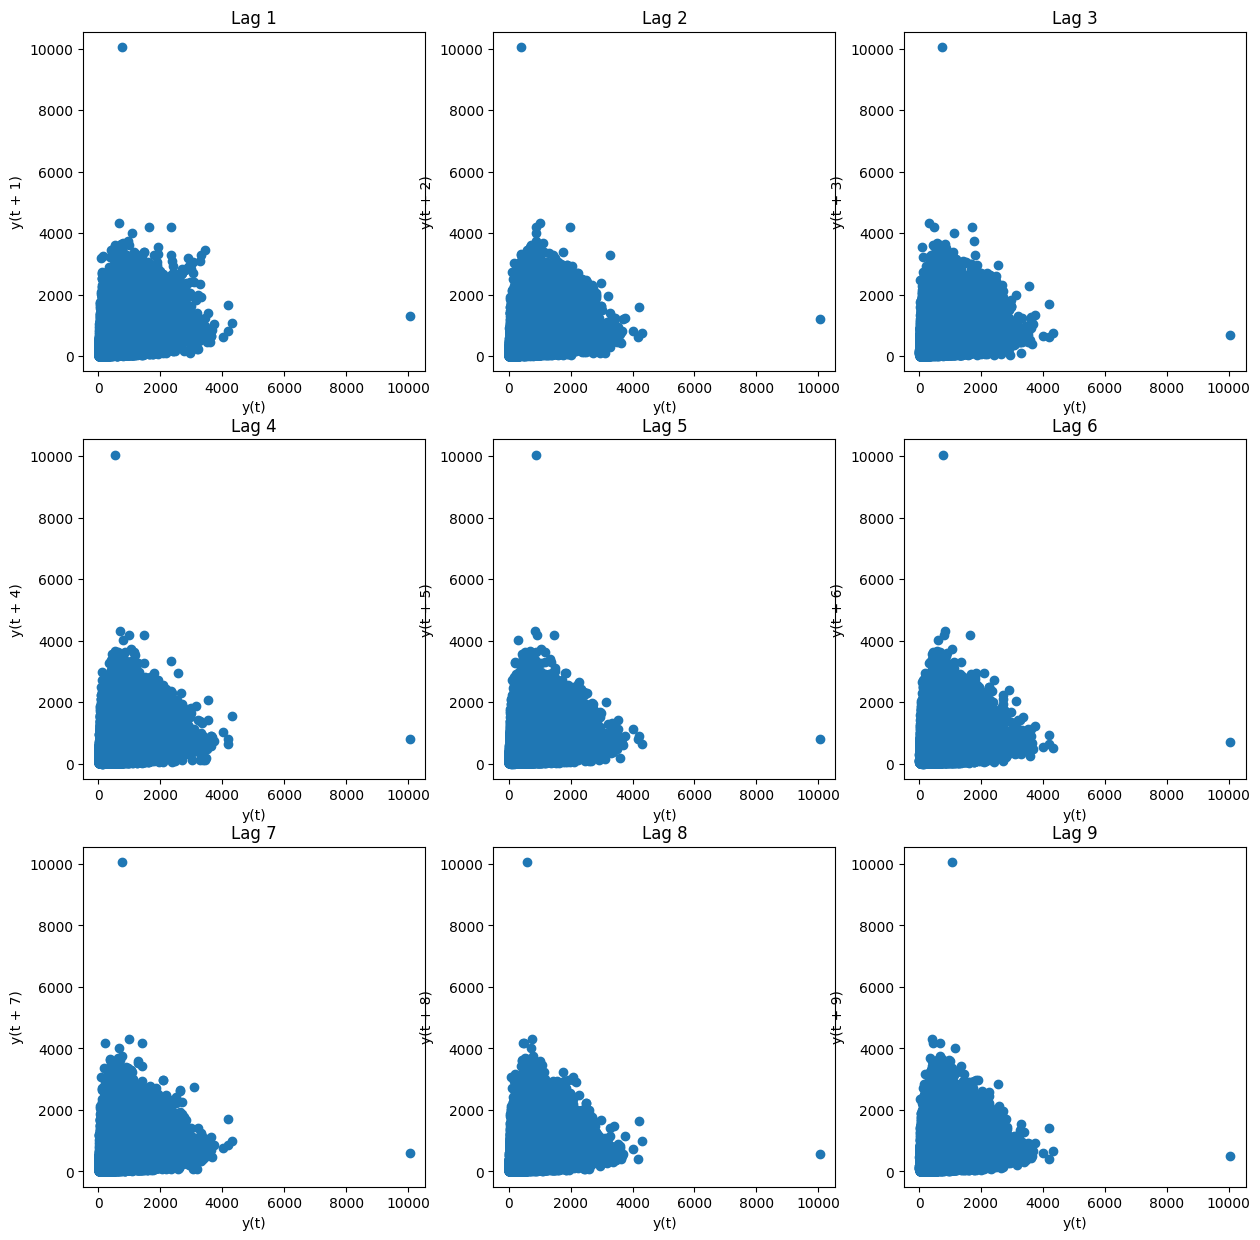

In [24]:
# 필요한 함수 불러오기
from pandas.plotting import lag_plot 

# Lag에 따른 시각화
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i, ax in enumerate(axes.flatten(), 1):
    lag_plot(df['deposit_by_area'], lag=i, ax=ax)
    ax.set_title(f'Lag {i}')
plt.show()


- 극단값을 처리해야된다.

In [25]:
df2 = df.drop(1588478)

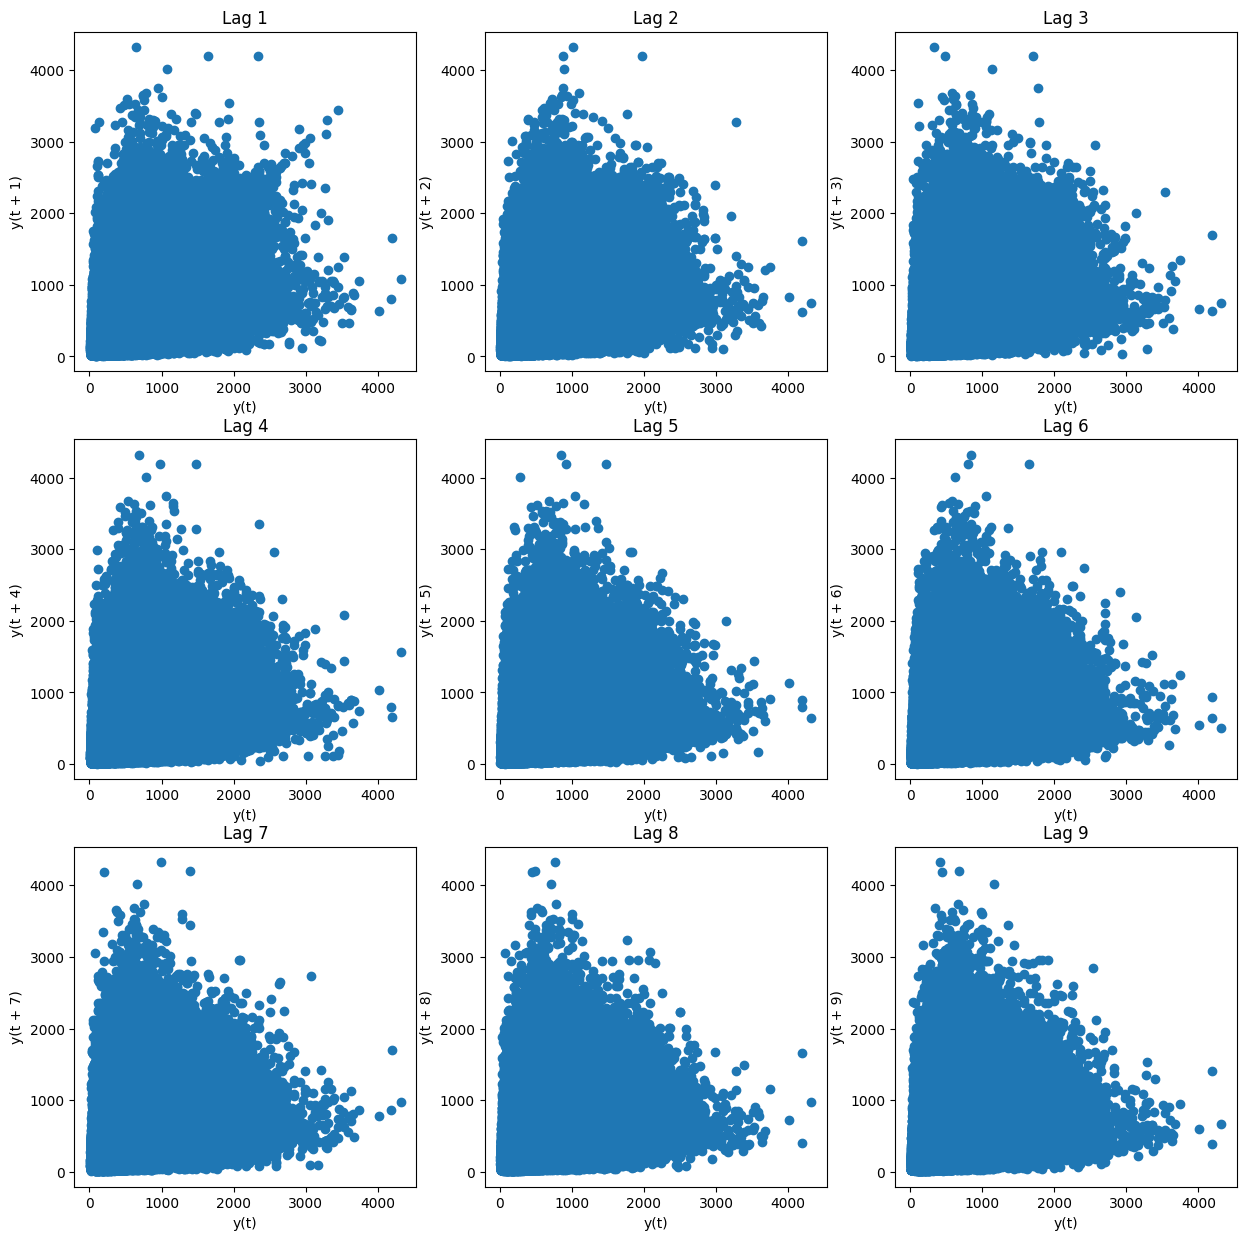

In [26]:
# 필요한 함수 불러오기
from pandas.plotting import lag_plot 

# Lag에 따른 시각화
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i, ax in enumerate(axes.flatten(), 1):
    lag_plot(df2['deposit_by_area'], lag=i, ax=ax)
    ax.set_title(f'Lag {i}')
plt.show()


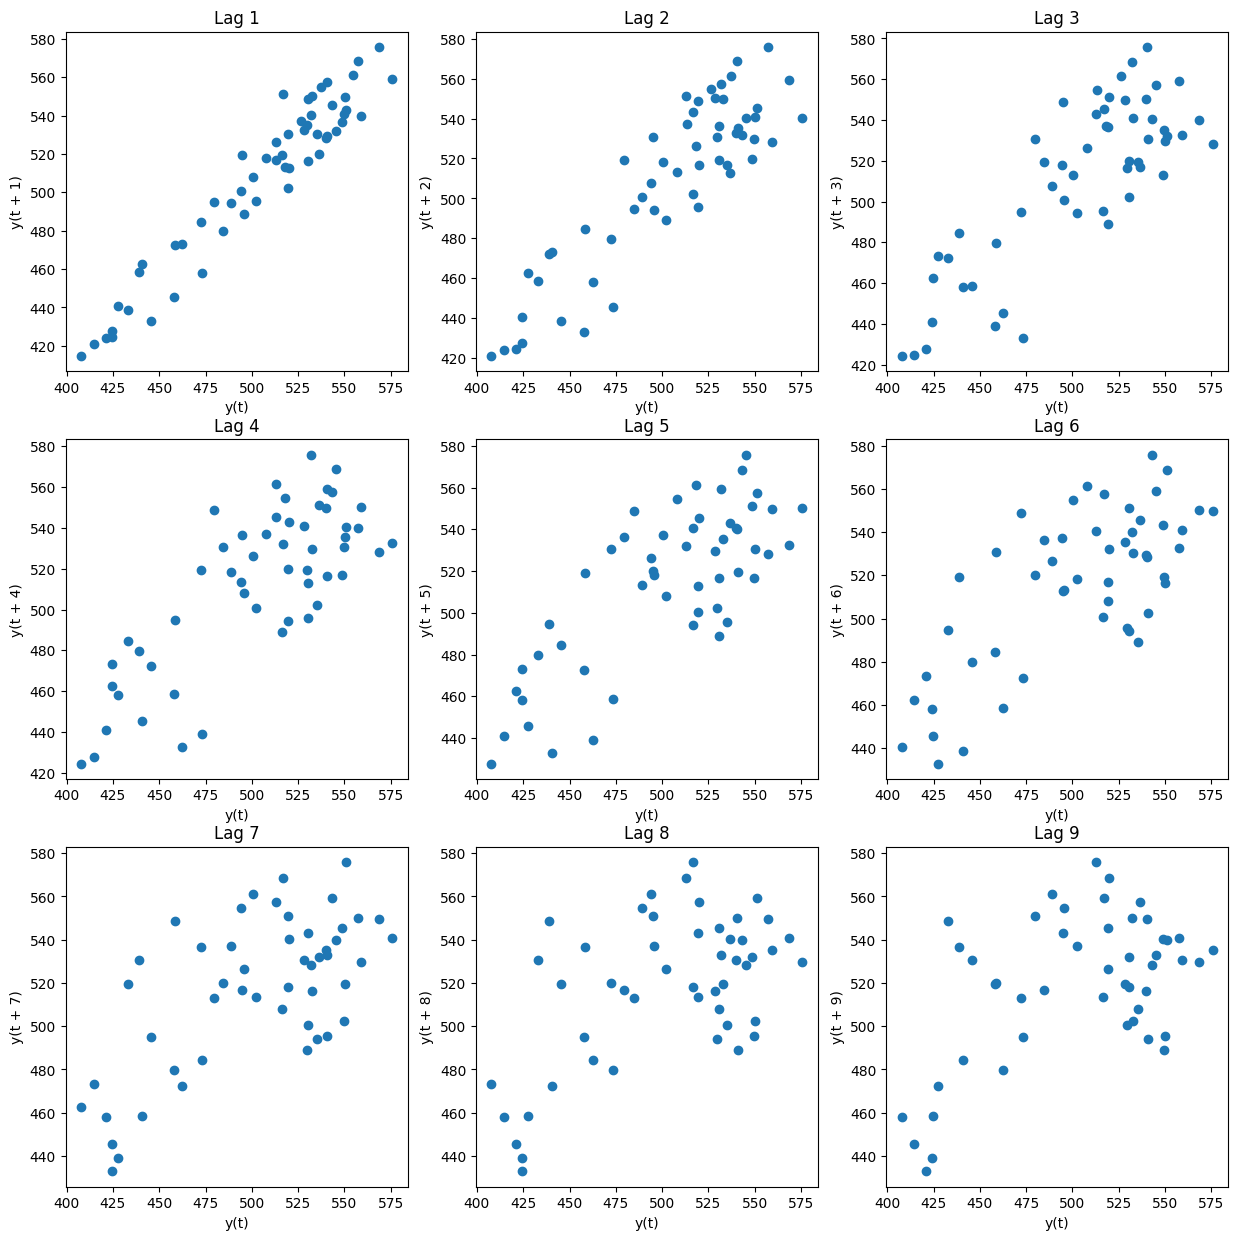

In [33]:
# 날짜별로 평균으로 보기
df2_aggregated = df2.groupby('contract_date')['deposit_by_area'].mean().reset_index()

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i, ax in enumerate(axes.flatten(), 1):
    lag_plot(df2_aggregated['deposit_by_area'], lag=i, ax=ax)
    ax.set_title(f'Lag {i}')
plt.show()


## 2. 자기 상관 관계와 백색 잡음
 자기상관 함수(Autocorrelation Function, ACF)는 시점 간의 상관관계를 측정하는 함수로, 현재 시점의 데이터가 과거 시점의 데이터와 얼마나 관련이 있는지를 나타냄

자기 상관 계수

$$
\rho_l =  \frac{\gamma_l}{\gamma_0} = \frac{\text{Cov}(r_t, r_{t-l})}{\sqrt{\text{Var}(r_t) \, \text{Var}(r_{t-l})}}
$$
- 1에 가까울수록 시점 간의 상관 관계가 강하다는 것을 의미


In [29]:
def autocorrelation(data, lag=1):
    """
    Calculate the autocorrelation of a time series.

    Parameters:
    data (array-like): Input time series data.
    lag (int): The lag for which to calculate the autocorrelation.

    Returns:
    float: The autocorrelation coefficient at the specified lag.
    """
    n = len(data)
    if lag >= n:
        raise ValueError("Lag must be less than the length of the data.")
    
    # Calculate mean of the data
    mean = np.mean(data)
    
    # Calculate autocovariance
    autocovariance = np.sum((data[:n - lag] - mean) * (data[lag:] - mean)) / n
    
    # Calculate variance
    variance = np.var(data)
    
    # Calculate autocorrelation
    autocorr = autocovariance / variance
    
    return autocorr



In [34]:
time_series_data = df2_aggregated['deposit_by_area']
lag = 1
result = autocorrelation(time_series_data, lag)
for lag in range(1, 13):
    result = autocorrelation(time_series_data, lag)
    print(f"Autocorrelation at lag {lag}: {result}")

Autocorrelation at lag 1: 0.8300320888569304
Autocorrelation at lag 2: 0.7654079351668673
Autocorrelation at lag 3: 0.7096338130143713
Autocorrelation at lag 4: 0.6580030527685878
Autocorrelation at lag 5: 0.6067110151985611
Autocorrelation at lag 6: 0.5593363499931964
Autocorrelation at lag 7: 0.501687278495691
Autocorrelation at lag 8: 0.4678620477222607
Autocorrelation at lag 9: 0.4517862076003733
Autocorrelation at lag 10: 0.43070732801281997
Autocorrelation at lag 11: 0.4021143380247493
Autocorrelation at lag 12: 0.35956070817088664


### 표본 자기상관 함수

In [35]:
import numpy as np

def autocorrelation_coefficient(data, lag):
    """
    Calculate the autocorrelation coefficient for a given lag.

    Parameters:
    data (array-like): Input time series data.
    lag (int): The lag for which to calculate the autocorrelation.

    Returns:
    float: The autocorrelation coefficient at the specified lag.
    float: The mean of the time series.
    """
    n = len(data)
    if lag >= n:
        raise ValueError("Lag must be less than the length of the data.")
    
    # Calculate mean of the data
    mean_r = np.mean(data)
    
    # Calculate autocorrelation numerator
    numerator = np.sum((data[lag:] - mean_r) * (data[:-lag] - mean_r))
    
    # Calculate autocorrelation denominator
    denominator = np.sum((data - mean_r) ** 2)
    
    # Calculate autocorrelation coefficient
    rho_l = numerator / denominator
    
    return rho_l, mean_r


In [36]:
time_series_data = df2_aggregated['deposit_by_area']
lag = 1
result = autocorrelation(time_series_data, lag)
for lag in range(1, 13):
    autocorr_result, mean_result = autocorrelation_coefficient(time_series_data, lag)

    print(f"Autocorrelation at lag {lag}: {autocorr_result}")
    print(f"Mean of the time series: {mean_result}")



Autocorrelation at lag 1: 0.9174038876839757
Mean of the time series: 505.1492867620373
Autocorrelation at lag 2: 0.8459771915002219
Mean of the time series: 505.1492867620373
Autocorrelation at lag 3: 0.7843321091211473
Mean of the time series: 505.1492867620373
Autocorrelation at lag 4: 0.7272665320073867
Mean of the time series: 505.1492867620373
Autocorrelation at lag 5: 0.6705753325878833
Mean of the time series: 505.1492867620373
Autocorrelation at lag 6: 0.618213860518796
Mean of the time series: 505.1492867620373
Autocorrelation at lag 7: 0.5544964657057637
Mean of the time series: 505.1492867620373
Autocorrelation at lag 8: 0.5171106843246039
Mean of the time series: 505.1492867620373
Autocorrelation at lag 9: 0.4993426505056758
Mean of the time series: 505.1492867620373
Autocorrelation at lag 10: 0.4760449414878537
Mean of the time series: 505.1492867620373
Autocorrelation at lag 11: 0.444442163079986
Mean of the time series: 505.1492867620373
Autocorrelation at lag 12: 0.397

### ACF Plot

In [63]:
from statsmodels.tsa.stattools import acf

# deposit_by_area 열만 남기고 인덱스를 리셋하여 데이터프레임으로 변환
df2_numerical = df2_aggregated['deposit_by_area'].reset_index(drop=True)

# ACF 계산
acf_values = acf(df2_numerical[:-6], nlags=36)
print(acf_values)


[ 1.          0.90663575  0.79409064  0.69448458  0.62766643  0.58126572
  0.51239171  0.43985835  0.37092129  0.33559377  0.31676231  0.28783643
  0.22637444  0.12154328  0.02371233 -0.05780971 -0.10424288 -0.13827813
 -0.17944824 -0.2160016  -0.25059156 -0.24036869 -0.2200741  -0.21435873
 -0.23867501 -0.29156739 -0.31382388 -0.33082165 -0.31700586 -0.30137696
 -0.28841218 -0.26788237 -0.24548912 -0.19120959 -0.14474337 -0.1205372
 -0.12284852]


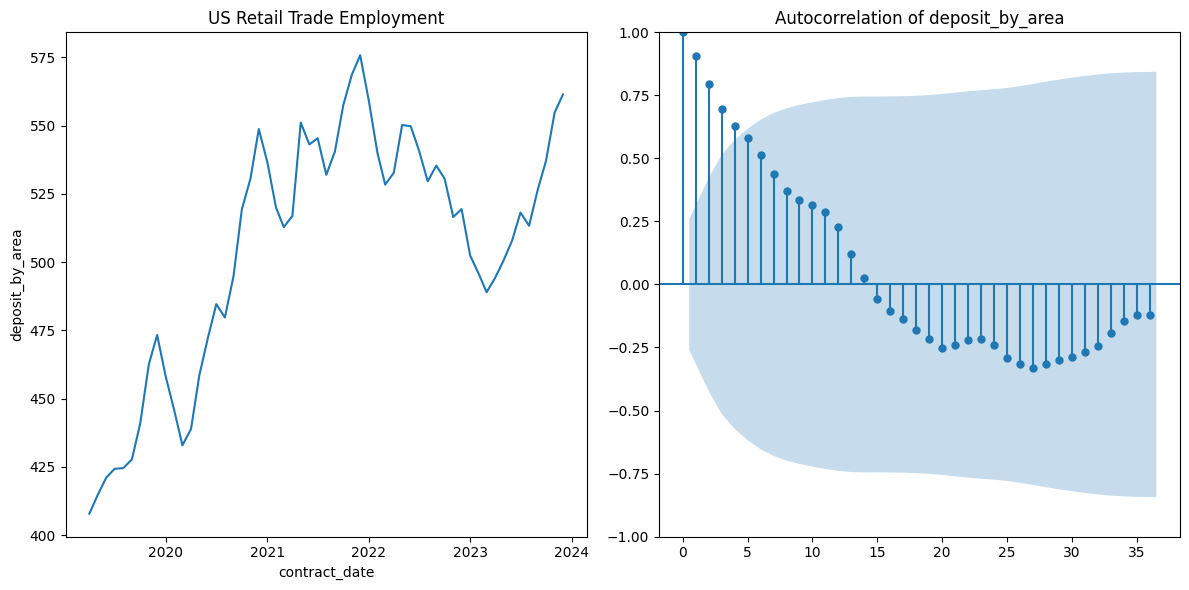

In [65]:
from statsmodels.graphics.tsaplots import plot_acf

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

x = df2_aggregated['contract_date'].to_numpy()
y = df2_aggregated['deposit_by_area'].to_numpy()

ax1.plot(x, y)
ax1.set_title('US Retail Trade Employment')
ax1.set_xlabel('contract_date')
ax1.set_ylabel('deposit_by_area')

plot_acf(df2_numerical[:-6], lags=36, ax=ax2)
ax2.set_title('Autocorrelation of deposit_by_area')

plt.tight_layout()
plt.show()


- 최근 가격에 영향을 받고 있다.

### 자기 상관 함수의 검정
- Ljung-Box 검정 (융-박스 검정)
  - 시계열 데이터에서 자기상관이 있는지를 검정하는 통계적 방법 
  - 귀무가설 : 잔차는 서로 독립적이다
  - 자기상관이 없는 경우(즉, 시계열 데이터가 독립적일 경우) 가정하고, 주어진 lag에 대해 자기상관의 유의성을 평가

In [66]:
import pandas as pd
from statsmodels.stats.diagnostic import acorr_ljungbox

# 데이터 준비: NaN 값 제거
data = df2_aggregated['deposit_by_area'].dropna()

# Ljung-Box 검정 수행
# lags는 검정할 시차의 수를 설정 (예: 12개월)
ljung_box_result = acorr_ljungbox(data, lags=[12], return_df=True)

# 결과 출력
print(ljung_box_result)


       lb_stat     lb_pvalue
12  229.532171  2.493317e-42


In [86]:
ljung_box_result

,lb_stat,lb_pvalue
12,229.532171,2.493317e-42


- lb_stat가 클수록 데이터에 자기 상관이 존재할 가능성이 높다.
- lb_pvalue (p-value) 가 매우 낮으므로 귀무가설 기각, 잔차에는 자기 상관성이 존재한다. 백색 잡음이 아닐 가능성이 높다 -> 데이터에 자기 상관이 존재한다.

-> 
- 데이터의 안정성 파악(정상성)
- ARIMA 모델과 같은 자기회귀 모델을 사용해보자

## 3. 시계열 분해
- 데이터를 추세(Trend), 계절성(Seasonality), 그리고 잔차(Residual)라는 세 가지 주요 구성 요소로 나누는 작업

- STL 기법으로 분해

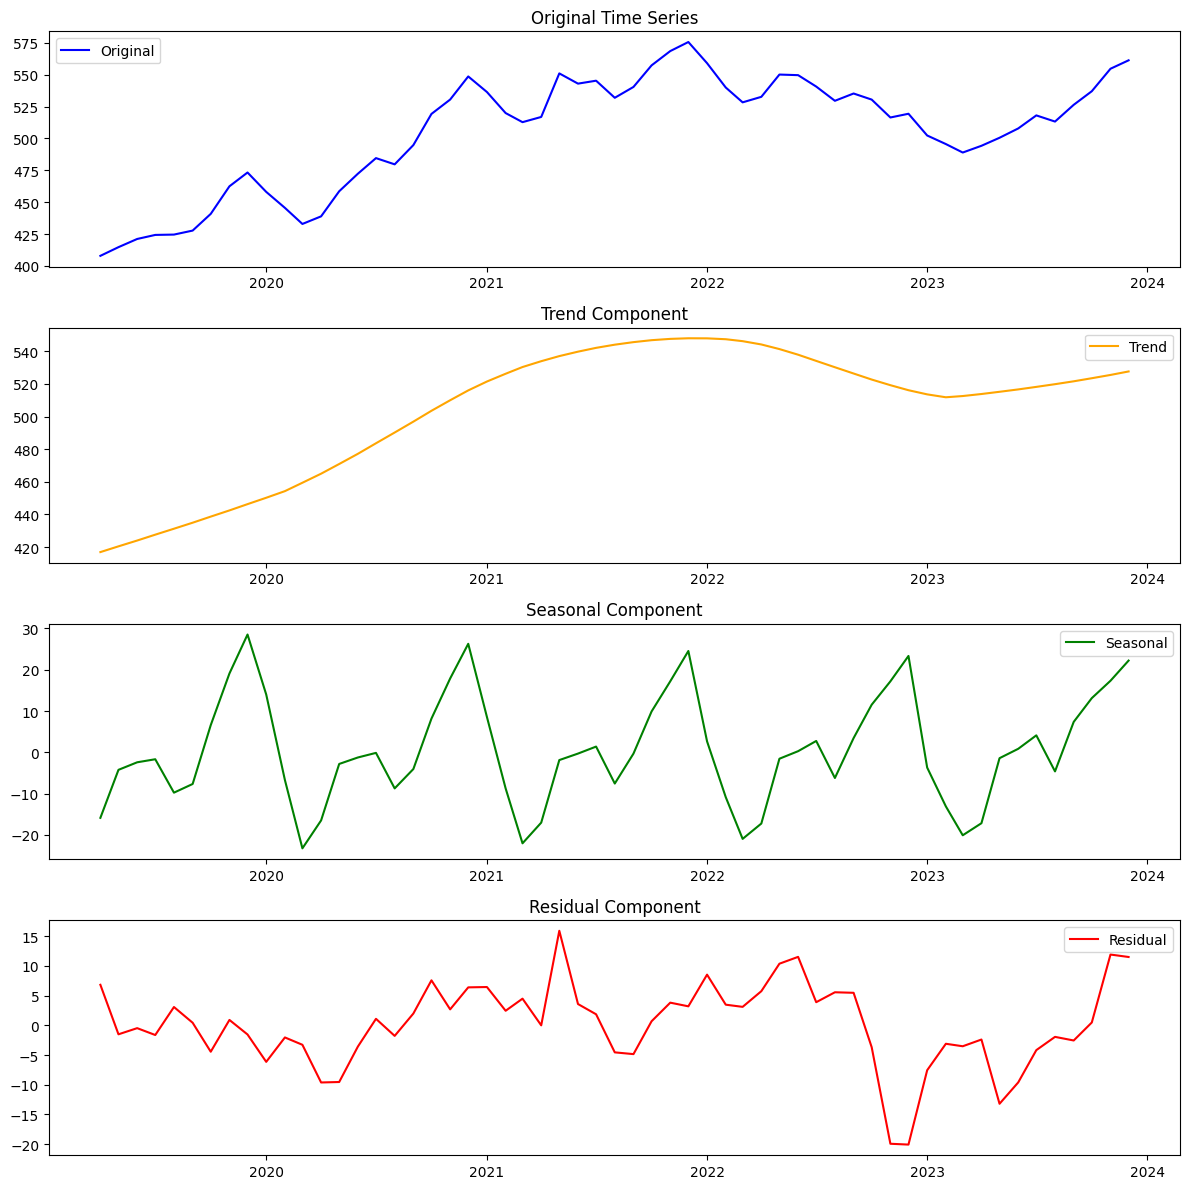

In [73]:
from statsmodels.tsa.seasonal import STL

data = df2_aggregated['deposit_by_area'][:-6]
data.index = df2_aggregated['contract_date'][:-6]

# STL 분해 수행
stl = STL(data, seasonal=13)  # seasonal은 계절성 주기를 나타냅니다
result = stl.fit()

# 분해 결과 시각화
fig, axes = plt.subplots(4, 1, figsize=(12, 12))

axes[0].plot(data, label='Original', color='blue')
axes[0].set_title('Original Time Series')
axes[0].legend()

axes[1].plot(result.trend, label='Trend', color='orange')
axes[1].set_title('Trend Component')
axes[1].legend()

axes[2].plot(result.seasonal, label='Seasonal', color='green')
axes[2].set_title('Seasonal Component')
axes[2].legend()

axes[3].plot(result.resid, label='Residual', color='red')
axes[3].set_title('Residual Component')
axes[3].legend()

plt.tight_layout()
plt.show()


그래프 해석
1) 원본 데이터
2) 추세 데이터
- 장기적으로 어떻게 변화해왔는지 분석
- 2022년 초까지 꾸준히 증가하다가 감소하다 다시 증가
3) 계절적 성분
- 연말에 가격이 오른다.
4) 잔차 성분 -> 추세와 계절성을 제거한 후 남은 불규칙한 변동 의미
- 2022년 말에 무슨 일이.....?

## 4. 이동 평균
- 이동 평균은 추세-주기 요소를 추정하는 가장 간단한 방법 중 하나
- 이동 평균을 통해 데이터의 노이즈를 제거하고 부드러운 추세와 주기성을 남길 수 있다.

- 이동평균 차수가 높아질수록 시계열 데이터에서의 변동성을 줄이고 더 부드러운 추세를 보여주지만, 반대로 단기적인 변동성은 덜 반영된다.

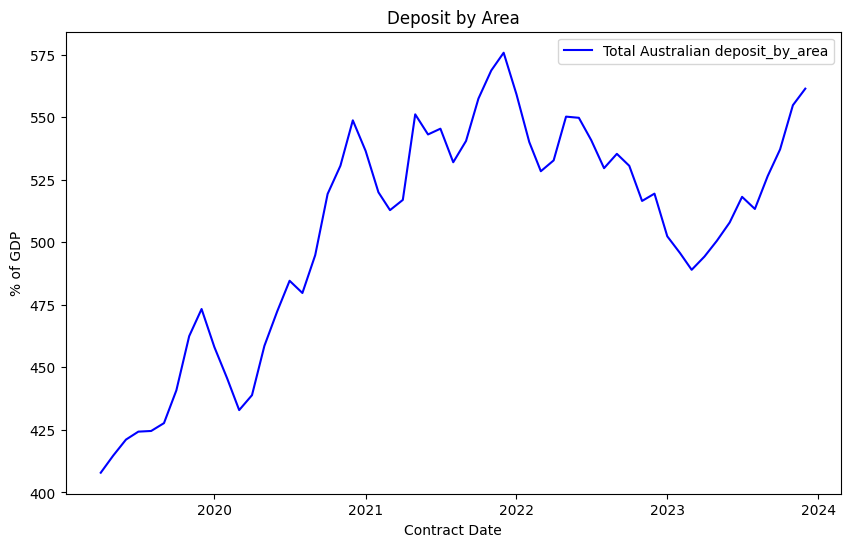

/tmp/ipykernel_756903/3568267234.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_aggregated['3-MA'] = df2_aggregated['deposit_by_area'].rolling(window=3, center=False).mean()
/tmp/ipykernel_756903/3568267234.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_aggregated['5-MA'] = df2_aggregated['deposit_by_area'].rolling(window=5, center=False).mean()
/tmp/ipykernel_756903/3568267234.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

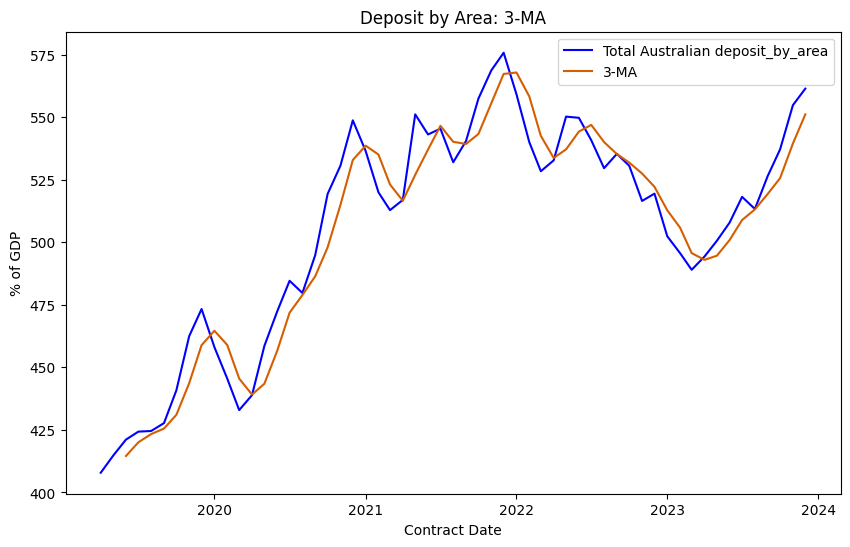

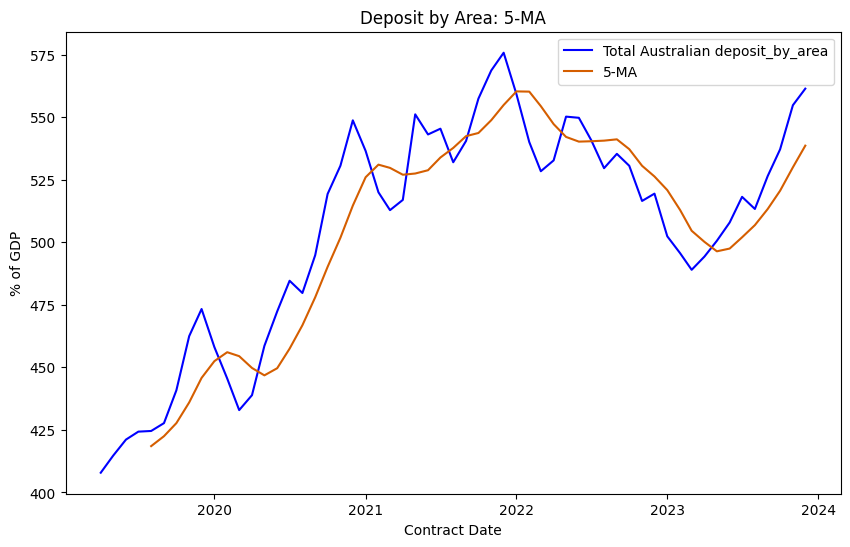

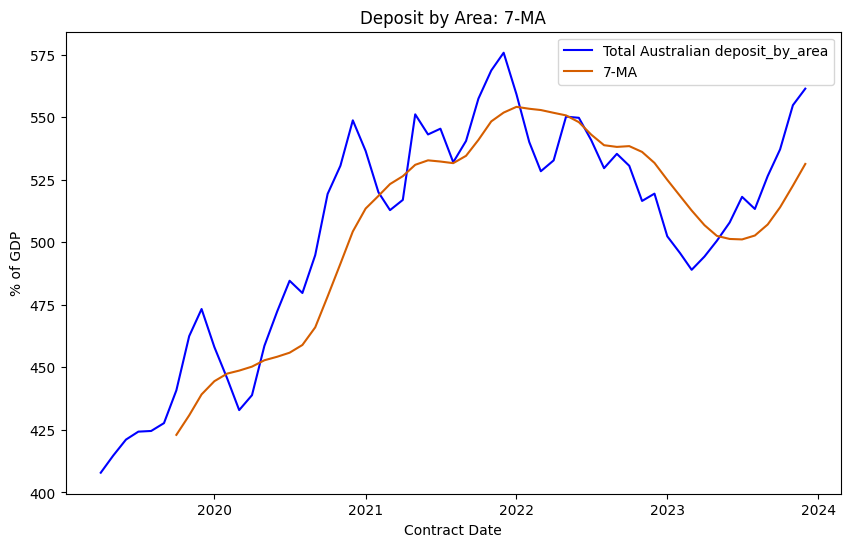

In [78]:
df2_aggregated = df2_aggregated.dropna(subset=['deposit_by_area'])

# 데이터 시각화
plt.figure(figsize=(10, 6))
plt.plot(df2_aggregated['contract_date'], df2_aggregated['deposit_by_area'], label='Total Australian deposit_by_area', color='blue')
plt.xlabel('Contract Date')
plt.ylabel('% of GDP')
plt.title('Deposit by Area')
plt.legend()
plt.show()

# 이동 평균 적용
df2_aggregated['3-MA'] = df2_aggregated['deposit_by_area'].rolling(window=3, center=False).mean()
df2_aggregated['5-MA'] = df2_aggregated['deposit_by_area'].rolling(window=5, center=False).mean()
df2_aggregated['7-MA'] = df2_aggregated['deposit_by_area'].rolling(window=7, center=False).mean()

# 3-MA 시각화
plt.figure(figsize=(10, 6))
plt.plot(df2_aggregated['contract_date'], df2_aggregated['deposit_by_area'], label='Total Australian deposit_by_area', color='blue')
plt.plot(df2_aggregated['contract_date'], df2_aggregated['3-MA'], label='3-MA', color='#D55E00')
plt.xlabel('Contract Date')
plt.ylabel('% of GDP')
plt.title('Deposit by Area: 3-MA')
plt.legend()
plt.show()

# 5-MA 시각화
plt.figure(figsize=(10, 6))
plt.plot(df2_aggregated['contract_date'], df2_aggregated['deposit_by_area'], label='Total Australian deposit_by_area', color='blue')
plt.plot(df2_aggregated['contract_date'], df2_aggregated['5-MA'], label='5-MA', color='#D55E00')
plt.xlabel('Contract Date')
plt.ylabel('% of GDP')
plt.title('Deposit by Area: 5-MA')
plt.legend()
plt.show()

# 7-MA 시각화
plt.figure(figsize=(10, 6))
plt.plot(df2_aggregated['contract_date'], df2_aggregated['deposit_by_area'], label='Total Australian deposit_by_area', color='blue')
plt.plot(df2_aggregated['contract_date'], df2_aggregated['7-MA'], label='7-MA', color='#D55E00')
plt.xlabel('Contract Date')
plt.ylabel('% of GDP')
plt.title('Deposit by Area: 7-MA')
plt.legend()
plt.show()


<Figure size 1000x600 with 0 Axes>

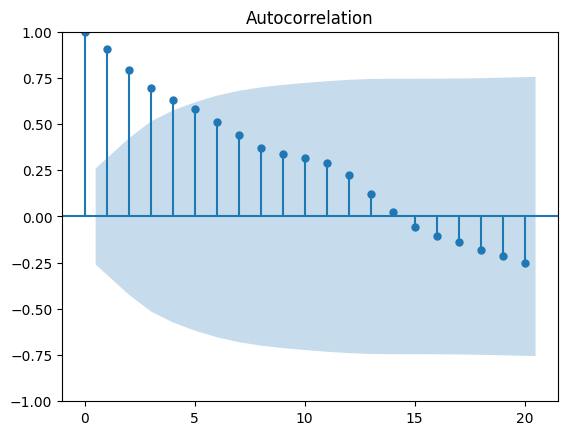

지연 12에서 ACF 계수가 유의하지 않음: 0.2264


In [75]:
### 책 보고 한 부분


from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf

data = df2_aggregated['deposit_by_area'][:-6]  # 랜덤 데이터를 시계열로 사용

# ACF 계산 및 시각화
lag_acf = acf(data, nlags=20)  # 최대 20 지연까지 계산
plt.figure(figsize=(10, 6))
plot_acf(data, lags=20)
plt.show()

# 유의하지 않은 시점 찾기 (q 이후 ACF 값이 유의하지 않은지 확인)
significance_threshold = 1.96 / np.sqrt(len(data))  # 통계적 유의성 기준 (95% 신뢰구간)

for i, coeff in enumerate(lag_acf):
    if abs(coeff) < significance_threshold:
        print(f"지연 {i}에서 ACF 계수가 유의하지 않음: {coeff:.4f}")
        break


-> MA(12) 로 분석을 하면 된다는 건가????

# 5.  ARIMA 모델

### 정상성
- 2가지 종류
1. 엄격한 정상성(Strict stationarity) : 엄격한 정상성은 시계열의 확률 밀도 함수
2. 약한 정상성(Weak stationarity) : 약한 정상성은 시계열의 평균과 시차에 따른 시계열의 자기상관 공분산이 시간에 대해 일정함을 요구
>- 시계열의 평균이 시간에 따라 일정해야 하며
>- 시계열r_t과 시점 차이가 l인 시계열 r_(t-l) 사이의 공분산이 시간에 관계없이 일정해야 한다.

#### 정상성 여부 검정
1. ADF 검정
- 귀무가설(H0): 데이터가 비정상적이다

In [79]:
from statsmodels.tsa.stattools import adfuller

data = df2_aggregated['deposit_by_area'].dropna()

# ADF 검정 수행
adf_result = adfuller(data)
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'  {key}: {value}')


ADF Statistic: -2.2244644412599612
p-value: 0.19748638217147613
Critical Values:
  1%: -3.5812576580093696
  5%: -2.9267849124681518
  10%: -2.6015409829867675


2. KPSS 검정
- 귀무가설(H0): 데이터가 정상적이다.

In [80]:
from statsmodels.tsa.stattools import kpss

# KPSS 검정 수행
kpss_result = kpss(data)
print('KPSS Statistic:', kpss_result[0])
print('p-value:', kpss_result[1])
print('Critical Values:')
for key, value in kpss_result[3].items():
    print(f'  {key}: {value}')


KPSS Statistic: 0.7531606157947132
p-value: 0.01
Critical Values:
  10%: 0.347
  5%: 0.463
  2.5%: 0.574
  1%: 0.739


/tmp/ipykernel_756903/3220260549.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(data)


- 결과는 데이터가 비정상적일 가능성이 높다
- 따라서 ARIMA 모델과 같은 정상성을 요구하는 모델을 적용하기 전에, 차분(differencing)과 같은 방법으로 데이터를 정상화해야 할 필요가 있다.

# 3. ACF, PCAF plot 시각화
https://velog.io/@phs5145/%EC%8B%9C%EA%B3%84%EC%97%B4-%EC%A0%95%EC%83%81%EC%84%B1%EA%B3%BC-%EB%B9%84%EC%A0%95%EC%83%81%EC%84%B1

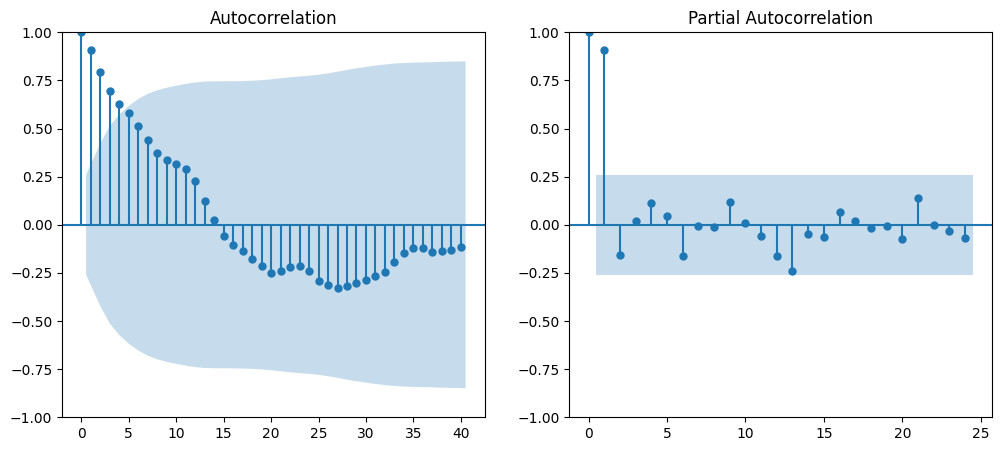

In [85]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plot_acf(data, lags=40, ax=ax[0])
plot_pacf(data, lags=24, ax=ax[1])
plt.show()


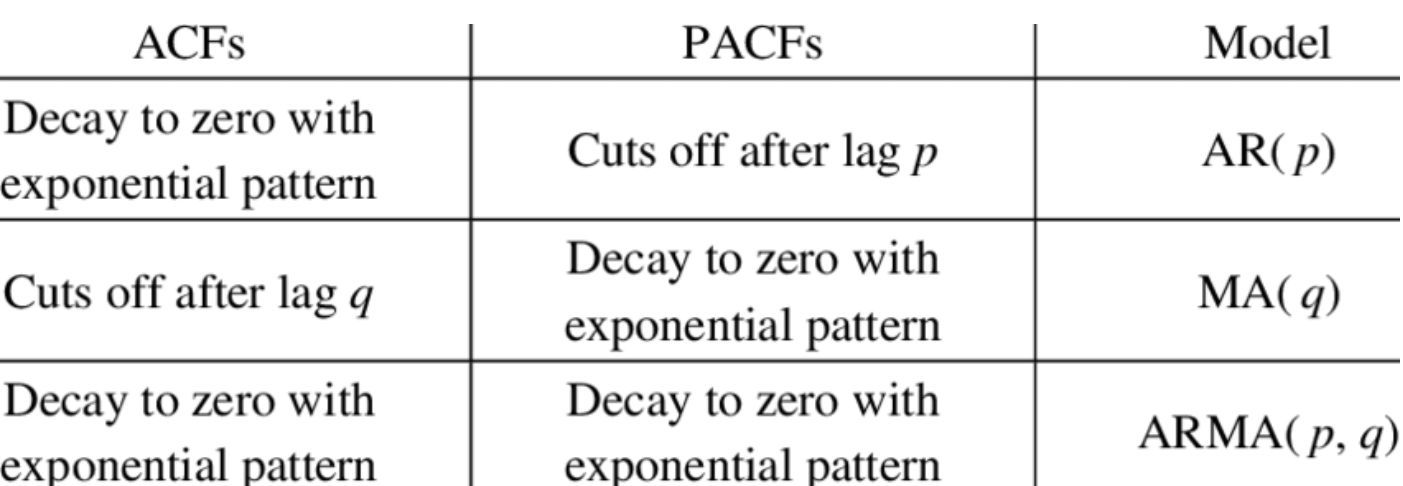

- ACF는 빠른 속도로 범위 안에 들어가고 있고
- PACF는 2 이후에 범위 안으로 들어감
-> AR(2) 모델을 사용하는 것이 적합하다??????

### 정상성을 띄는 데이터로 만드는 방법
1. 차분(ARIMA 에서 d)
2. 로그 변환
3. 로그 차분

In [ ]:
# 865555555555555555555555555555555555555555555555555555555555

